## Main Jupyter Notebooks for implementing the German Traffic Sign Classification CNN

# Read in Data

In [16]:
# Standard libraries
import os
import math
from collections import defaultdict

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Torchvision libraries
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Visualization
import matplotlib.pyplot as plt

# Machine Learning
import numpy as np  # Für numerische Berechnungen
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# LIME and segmentation for explanations
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries, slic

# Image processing
from PIL import Image  # Für das Öffnen und Konvertieren von Bildern


/Users/linuspfeifer/opt/anaconda3/envs/xai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the selected device to ensure clarity for the user
print(f"Using device: {device}")



Using device: cpu


In [19]:
# Here our mean and our std are calculated for the normalization of the images
transform_mean_std = transforms.Compose([
    transforms.Resize((35, 35)),  
    transforms.ToTensor(),
])
dataset = ImageFolder("GTSRB/Final_Training/Images", transform=transform_mean_std)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean = 0.
std = 0.
total_images_count = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_samples

mean /= total_images_count
std /= total_images_count

print(f"Mean: {mean}")
print(f"Std: {std}")


Mean: tensor([0.3433, 0.3151, 0.3253])
Std: tensor([0.1690, 0.1713, 0.1815])


In [20]:
# Define transform for importing test and training data
img_size = 35 
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()) 
])

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),  
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0308585..1.5713207].


Label: 50_kmh


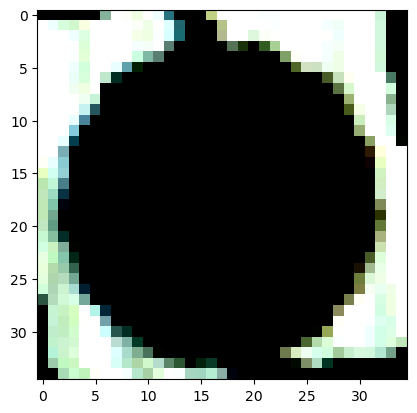

In [21]:
# Reading in the data and subsequent output of an image incl. label for checking
train_dataset = ImageFolder(root='GTSRB/Final_Training/Images', transform=transform)
train_transforms_dataset = ImageFolder(root='GTSRB/Final_Training/Images', transform=train_transforms)

test_dataset = ImageFolder(root='GTSRB/Final_Test/Images', transform=transform)

batch_size = 64
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
num_classes = 43

# --------- Testing ---------
img, label = train_transforms_dataset[4000]
label_string = test_dataset.classes[label]
print("Label:", label_string)
plt.imshow(img.permute(1, 2, 0))

# Create the Model


In [22]:
# Model that was used for training
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Convolutional Layers
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)

        # Since we have also trained with different image sizes, we have written an auxiliary function that calculates what kind of vector with how many dimensions comes out of the conv layers
        self.flatten = nn.Flatten()
        dummy_input = torch.zeros(batch_size, 3, img_size, img_size)
        fc_input_size = self._get_fc_input_size(dummy_input)

        # Fully Connected Layers
        self.fc6 = nn.Linear(fc_input_size, 512)
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()

        self.fc9 = nn.Linear(128, num_classes)

    def _get_fc_input_size(self, dummy_input):
        # Auxiliary function to calculate the input size for the Fully Connected Layers
        with torch.no_grad():
            x = self.conv_layer1(dummy_input)
            x = self.relu1(x)
            x = self.max_pool1(x)

            x = self.conv_layer2(x)
            x = self.relu2(x)
            x = self.max_pool2(x)

            x = self.conv_layer3(x)
            x = self.relu3(x)

            x = self.conv_layer4(x)
            x = self.relu4(x)

            x = self.conv_layer5(x)
            x = self.relu5(x)
            x = self.max_pool5(x)

            x = self.flatten(x)
        return x.size(1)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = self.flatten(out)  
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out


### Different CNN Model

In [ ]:
# We have tested a different model in two places here. However, this was not pursued any further
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(64 * 7 * 7, 750) 
        self.bn5 = nn.BatchNorm1d(750)
        self.dropout2 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(750, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, 43)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(self.bn3(x))
        
        x = F.relu(self.bn4(self.conv3(x)))
        x = self.pool2(x)
        x = self.dropout1(x)
        
        x = self.flatten(x)
        
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.dropout3(x)
        
        x = F.softmax(self.fc3(x), dim=1)
        return x


# Training

### Initialization of the model and definition of hyperparameters


In [ ]:
# Initialization of the model
model = CNN(num_classes).to(device)
loss_func = nn.CrossEntropyLoss()

# Initial learning rate and optimizer
lr = 0.01
weight_decay = 0.001
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

# At times we have also used a ReduceLROnPlateau Scheduler. However, this approach was not pursued further on.
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.001)

#### Initialization of the model and definition of hyperparameters and get the Activation of the Model Layers 

In [ ]:
# Dictionary to store activations
activations = {}

# Function to create hooks that capture activations
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Initialize the model and move it to the selected device (CPU or GPU)
model = CNN(num_classes=43).to(device)

# Define the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
lr = 0.01
weight_decay = 0.001
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

# Register hooks for each convolutional layer and its ReLU activation
model.conv_layer1.register_forward_hook(get_activation('conv_layer1'))
model.conv_layer2.register_forward_hook(get_activation('conv_layer2'))
model.conv_layer3.register_forward_hook(get_activation('conv_layer3'))
model.conv_layer4.register_forward_hook(get_activation('conv_layer4'))
model.conv_layer5.register_forward_hook(get_activation('conv_layer5'))

model.relu1.register_forward_hook(get_activation('relu1'))
model.relu2.register_forward_hook(get_activation('relu2'))
model.relu3.register_forward_hook(get_activation('relu3'))
model.relu4.register_forward_hook(get_activation('relu4'))
model.relu5.register_forward_hook(get_activation('relu5'))

# Register hooks for each fully connected layer and its ReLU activation
model.fc6.register_forward_hook(get_activation('fc6'))
model.fc7.register_forward_hook(get_activation('fc7'))
model.fc8.register_forward_hook(get_activation('fc8'))
model.fc9.register_forward_hook(get_activation('fc9'))

model.relu6.register_forward_hook(get_activation('relu6'))
model.relu7.register_forward_hook(get_activation('relu7'))
model.relu8.register_forward_hook(get_activation('relu8'))


### Calculate Accuracy Function

In [23]:
# A function is defined here to calculate the accuracy of the model during and after training
def calculate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad(): 
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

### Default Training

In [ ]:
# This is the default training, without any plots.
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save model
torch.save(model.state_dict(), 'model/new_cnn_architecture.pth')

## Train model with plot

### Visualization while Training (with PCA)

In [ ]:
# Here we train our model with different plots. The training is basically the same, but Accuracy, Loss, PCA and the activation of the last layer are also plotted
last_layer_weights = []
pca_results = []

num_epochs = 100
train_accuracies = []
test_accuracies = []
train_losses = []

plt.figure(figsize=(12, 8))

# The loader is also defined here. During the training, we realized that we can partially solve our problem with overfitting through data augmentation. We have therefore structured the training in such a way that we train with the normal training data as long as the loss decreases. As soon as the loss does not decrease from one epoch to the next, the loader is switched to the data with data augmentation and 10 further epochs are trained

current_loader = train_loader
previous_loss = float('inf')
switch_epoch = None 

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0 

    for i, (images, labels) in enumerate(current_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() 
        outputs = model(images) 
        loss = loss_func(outputs, labels) 
        loss.backward()  
        optimizer.step() 
        
        running_loss += loss.item() 

    
    avg_loss = running_loss / len(current_loader)

   
    train_accuracy = calculate_accuracy(model, current_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(avg_loss)

    print(f"Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    if avg_loss > previous_loss and current_loader == train_loader:
        print("Loss has increased. Switching to train_transforms_loader.")
        current_loader = train_transforms_loader 
        switch_epoch = epoch 
        print("Training will continue for exactly 10 epochs after loader switch.")

    
    previous_loss = avg_loss

   
    last_fc_weights = model.fc9.weight.data.cpu().numpy()  
    last_layer_weights.append(last_fc_weights)

    
    with torch.no_grad():
        pca = PCA(n_components=2)
        outputs_2d = pca.fit_transform(outputs.cpu().numpy())
    pca_results.append(outputs_2d)

    
    plt.clf()  
    plt.figure(figsize=(12, 8))

    # Plot 1: Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot 2: Loss
    plt.subplot(2, 2, 2)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot 3: PCA of Output Vectors
    plt.subplot(2, 2, 3)
    plt.scatter(outputs_2d[:, 0], outputs_2d[:, 1], c=labels.cpu().numpy(), cmap='viridis', s=10)
    plt.colorbar(label='Class Index')
    plt.title('PCA of Output Vectors')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')

    # Plot 4: Visualization of the last layer weights
    plt.subplot(2, 2, 4)
    plt.imshow(last_fc_weights, cmap='coolwarm', aspect='auto')
    plt.colorbar(label='Weight Value')
    plt.title('Weights of Last FC Layer')
    plt.xlabel('Neurons')
    plt.ylabel('Classes')

    if switch_epoch is not None and epoch >= switch_epoch + 10:
            print(f"Stopping training after 10 epochs post-switch at epoch {epoch + 1}.")
            plt.savefig(f'model/optim_loop/RMSprop/train_{train_accuracy}_test_{test_accuracy}.png')
            break

    
    plt.tight_layout()
    plt.pause(0.1)


torch.save(model.state_dict(), f'model/train_{train_accuracy}_test_{test_accuracy}.pth')

plt.show()


#### Same with TSNE

In [ ]:
# The same is done here as in the code in the cell above. The difference is that TSNE is used here to visualize the output vectors
last_layer_weights = []
tsne_results = []

num_epochs = 100
train_accuracies = []
test_accuracies = []
train_losses = []

plt.figure(figsize=(12, 8))

current_loader = train_loader
previous_loss = float('inf')
switch_epoch = None 

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    running_loss = 0.0 

    for i, (images, labels) in enumerate(current_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() 
        outputs = model(images) 
        loss = loss_func(outputs, labels) 
        loss.backward() 
        optimizer.step()
        
        running_loss += loss.item()

    
    avg_loss = running_loss / len(current_loader)

    
    train_accuracy = calculate_accuracy(model, current_loader, device)
    test_accuracy = calculate_accuracy(model, test_loader, device)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_losses.append(avg_loss)

    print(f"Training Loss: {avg_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

   
    if avg_loss > previous_loss and current_loader == train_loader:
        print("Loss has increased. Switching to train_transforms_loader.")
        current_loader = train_transforms_loader  
        switch_epoch = epoch 
        print("Training will continue for exactly 10 epochs after loader switch.")

    
    previous_loss = avg_loss

    
    last_fc_weights = model.fc9.weight.data.cpu().numpy() 
    last_layer_weights.append(last_fc_weights)

    
    with torch.no_grad():
        tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
        outputs_2d = tsne.fit_transform(outputs.cpu().numpy())
    tsne_results.append(outputs_2d)

    
    plt.clf()
    plt.figure(figsize=(12, 8))
    # Plot 1: Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot 2: Loss
    plt.subplot(2, 2, 2)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Plot 3: t-SNE of Output Vectors 
    plt.subplot(2, 2, 3)
    plt.scatter(outputs_2d[:, 0], outputs_2d[:, 1], c=labels.cpu().numpy(), cmap='viridis', s=10)
    plt.colorbar(label='Class Index')
    plt.title('t-SNE of Output Vectors')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')

    # Plot 4: Visualization of the last layer weights
    plt.subplot(2, 2, 4)
    plt.imshow(last_fc_weights, cmap='coolwarm', aspect='auto')
    plt.colorbar(label='Weight Value')
    plt.title('Weights of Last FC Layer')
    plt.xlabel('Neurons')
    plt.ylabel('Classes')

    if switch_epoch is not None and epoch >= switch_epoch + 10:
        print(f"Stopping training after 10 epochs post-switch at epoch {epoch + 1}.")
        plt.savefig(f'model/optim_loop/RMSprop/train_{train_accuracy}_test_{test_accuracy}.png')
        break

    
    plt.tight_layout()
    plt.pause(0.1)


torch.save(model.state_dict(), f'model/train_{train_accuracy}_test_{test_accuracy}.pth')


plt.show()


# Test the Model

### Test the current Model

In [ ]:
# The current model can be tested here
def calculate_accuracy(model, data_loader, device):
    model.eval() 
    correct = 0
    total = 0
    
    with torch.no_grad(): 
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

model.to(device)

train_accuracy = calculate_accuracy(model, train_loader, device)
print(f"Accuracy on training data: {train_accuracy:.2f}%")


test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Accuracy on test data: {test_accuracy:.2f}%")

### Calculate Accuracy per Class

In [ ]:
# Here you can calculate how accurate the model is for the individual classes
def calculate_class_accuracy(model, data_loader, device):
    model.eval()
    
    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
    
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names

# Calculate accuracy for each class
class_accuracies, class_names = calculate_class_accuracy(model, test_loader, device)

# Plot the Accuracy per Class
plt.figure(figsize=(12, 8))
plt.bar(range(len(class_names)), class_accuracies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Class after Training')
plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.grid(axis='y')
plt.show()


### Calculate Accuracy per Class, save wrong predictions as number and then plot what was predicted instead of the correct prediction

In [ ]:
# Calculate Accuracy per Class, save wrong predictions as number and then plot what was predicted instead of the correct prediction
def calculate_class_accuracy_and_misclassifications(model, data_loader, device):
    model.eval()

    class_names = data_loader.dataset.classes
    num_classes = len(class_names)
    
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    misclassified_counts = defaultdict(lambda: [0] * num_classes)
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == labels[i]:
                    class_correct[label] += 1
                else:
                    misclassified_counts[label][predicted[i].item()] += 1  
    
    # Calculate class accuracy
    class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy, class_names, misclassified_counts


# Calculate class accuracy and misclassifications
class_accuracies, class_names, misclassified_counts = calculate_class_accuracy_and_misclassifications(model, test_loader, device)

# Plot misclassifications for classes with accuracy below 80%
for i, accuracy in enumerate(class_accuracies):
    if accuracy < 80:
        misclassified_counts_for_class = misclassified_counts[i]
        misclassified_class_names = [class_names[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        misclassified_class_counts = [misclassified_counts_for_class[j] for j in range(len(misclassified_counts_for_class)) if misclassified_counts_for_class[j] > 0]
        
        plt.figure(figsize=(8, 5))
        plt.bar(misclassified_class_names, misclassified_class_counts, color='salmon')
        plt.xlabel('Predicted Class')
        plt.ylabel('Count')
        plt.title(f"Misclassifications for Class '{class_names[i]}' (Accuracy: {accuracy:.2f}%)")
        plt.xticks(rotation=90)
        plt.grid(axis='y')
        plt.show()


### If you want to test an old model, you can do this right here

Define the CNN Model Class vor Evaluation. Make sure you replace this with the correct Conv Layers and FC Layers of your trained model. 

In [24]:
# If a different model, possibly even with a different architecture, is to be tested, the new architecture can be defined here
class Net(nn.Module):
    def __init__(self, num_classes, image_size = 35):
        super(Net, self).__init__()

        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv_layer4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv_layer5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.dropout6 = nn.Dropout(p=0.5)

       
        self.flatten = nn.Flatten()
        dummy_input = torch.zeros(batch_size, 3, image_size, image_size)  
        fc_input_size = self._get_fc_input_size(dummy_input)

        # Fully Connected Layers
        self.fc6 = nn.Linear(fc_input_size, 512)
        self.relu6 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7 = nn.ReLU()

        self.dropout8 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(256, 128)
        self.relu8 = nn.ReLU()

        self.fc9 = nn.Linear(128, num_classes)

    def _get_fc_input_size(self, dummy_input):

        with torch.no_grad():
            x = self.conv_layer1(dummy_input)
            x = self.relu1(x)
            x = self.max_pool1(x)

            x = self.conv_layer2(x)
            x = self.relu2(x)
            x = self.max_pool2(x)

            x = self.conv_layer3(x)
            x = self.relu3(x)

            x = self.conv_layer4(x)
            x = self.relu4(x)

            x = self.conv_layer5(x)
            x = self.relu5(x)
            x = self.max_pool5(x)

            x = self.flatten(x)
        return x.size(1)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)

        out = self.conv_layer2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)

        out = self.conv_layer3(out)
        out = self.relu3(out)

        out = self.conv_layer4(out)
        out = self.relu4(out)

        out = self.conv_layer5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)

        out = self.flatten(out)
        out = self.dropout6(out)
        out = self.fc6(out)
        out = self.relu6(out)

        out = self.dropout7(out)
        out = self.fc7(out)
        out = self.relu7(out)

        out = self.dropout8(out)
        out = self.fc8(out)
        out = self.relu8(out)

        out = self.fc9(out)

        return out


Provide now informations such as path and the number of output classes

In [86]:
# The model can then be loaded here. The activations for the image are also saved directly in the image path
image_path = 'GTSRB/Final_Test/Images/fussgaenger/03235.ppm'  

# Model path and check for existence
model_path = 'model/FINAL_Models/SGD_FINAL_image_size_35_train_95.37351118365682_test_95.16920367341804.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Das Modell unter '{model_path}' wurde nicht gefunden.")

activations = {}

# Hook function to capture activations
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Load the trained model
trained_model = Net(num_classes=43)
trained_model.to(device)
trained_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Register hooks for the layers
trained_model.conv_layer1.register_forward_hook(get_activation('conv_layer1'))
trained_model.conv_layer2.register_forward_hook(get_activation('conv_layer2'))
trained_model.conv_layer3.register_forward_hook(get_activation('conv_layer3'))
trained_model.conv_layer4.register_forward_hook(get_activation('conv_layer4'))
trained_model.conv_layer5.register_forward_hook(get_activation('conv_layer5'))
trained_model.relu1.register_forward_hook(get_activation('relu1'))
trained_model.relu2.register_forward_hook(get_activation('relu2'))
trained_model.relu3.register_forward_hook(get_activation('relu3'))
trained_model.relu4.register_forward_hook(get_activation('relu4'))
trained_model.relu5.register_forward_hook(get_activation('relu5'))
trained_model.fc6.register_forward_hook(get_activation('fc6'))
trained_model.fc7.register_forward_hook(get_activation('fc7'))
trained_model.fc8.register_forward_hook(get_activation('fc8'))
trained_model.fc9.register_forward_hook(get_activation('fc9'))
trained_model.relu6.register_forward_hook(get_activation('relu6'))
trained_model.relu7.register_forward_hook(get_activation('relu7'))
trained_model.relu8.register_forward_hook(get_activation('relu8'))

# Main function to process the image
if __name__ == "__main__":
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Das Bild unter '{image_path}' wurde nicht gefunden.")
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    
    image = image.to(device)
    output = trained_model(image)
    
    print("Forward-Pass abgeschlossen.")
    print("Gespeicherte Aktivierungen:", activations.keys())


Forward-Pass abgeschlossen.
Gespeicherte Aktivierungen: dict_keys(['conv_layer1', 'relu1', 'conv_layer2', 'relu2', 'conv_layer3', 'relu3', 'conv_layer4', 'relu4', 'conv_layer5', 'relu5', 'fc6', 'relu6', 'fc7', 'relu7', 'fc8', 'relu8', 'fc9'])


# Visualisation and Explainable Part 

Shape of conv1 activations: torch.Size([1, 64, 34, 34])


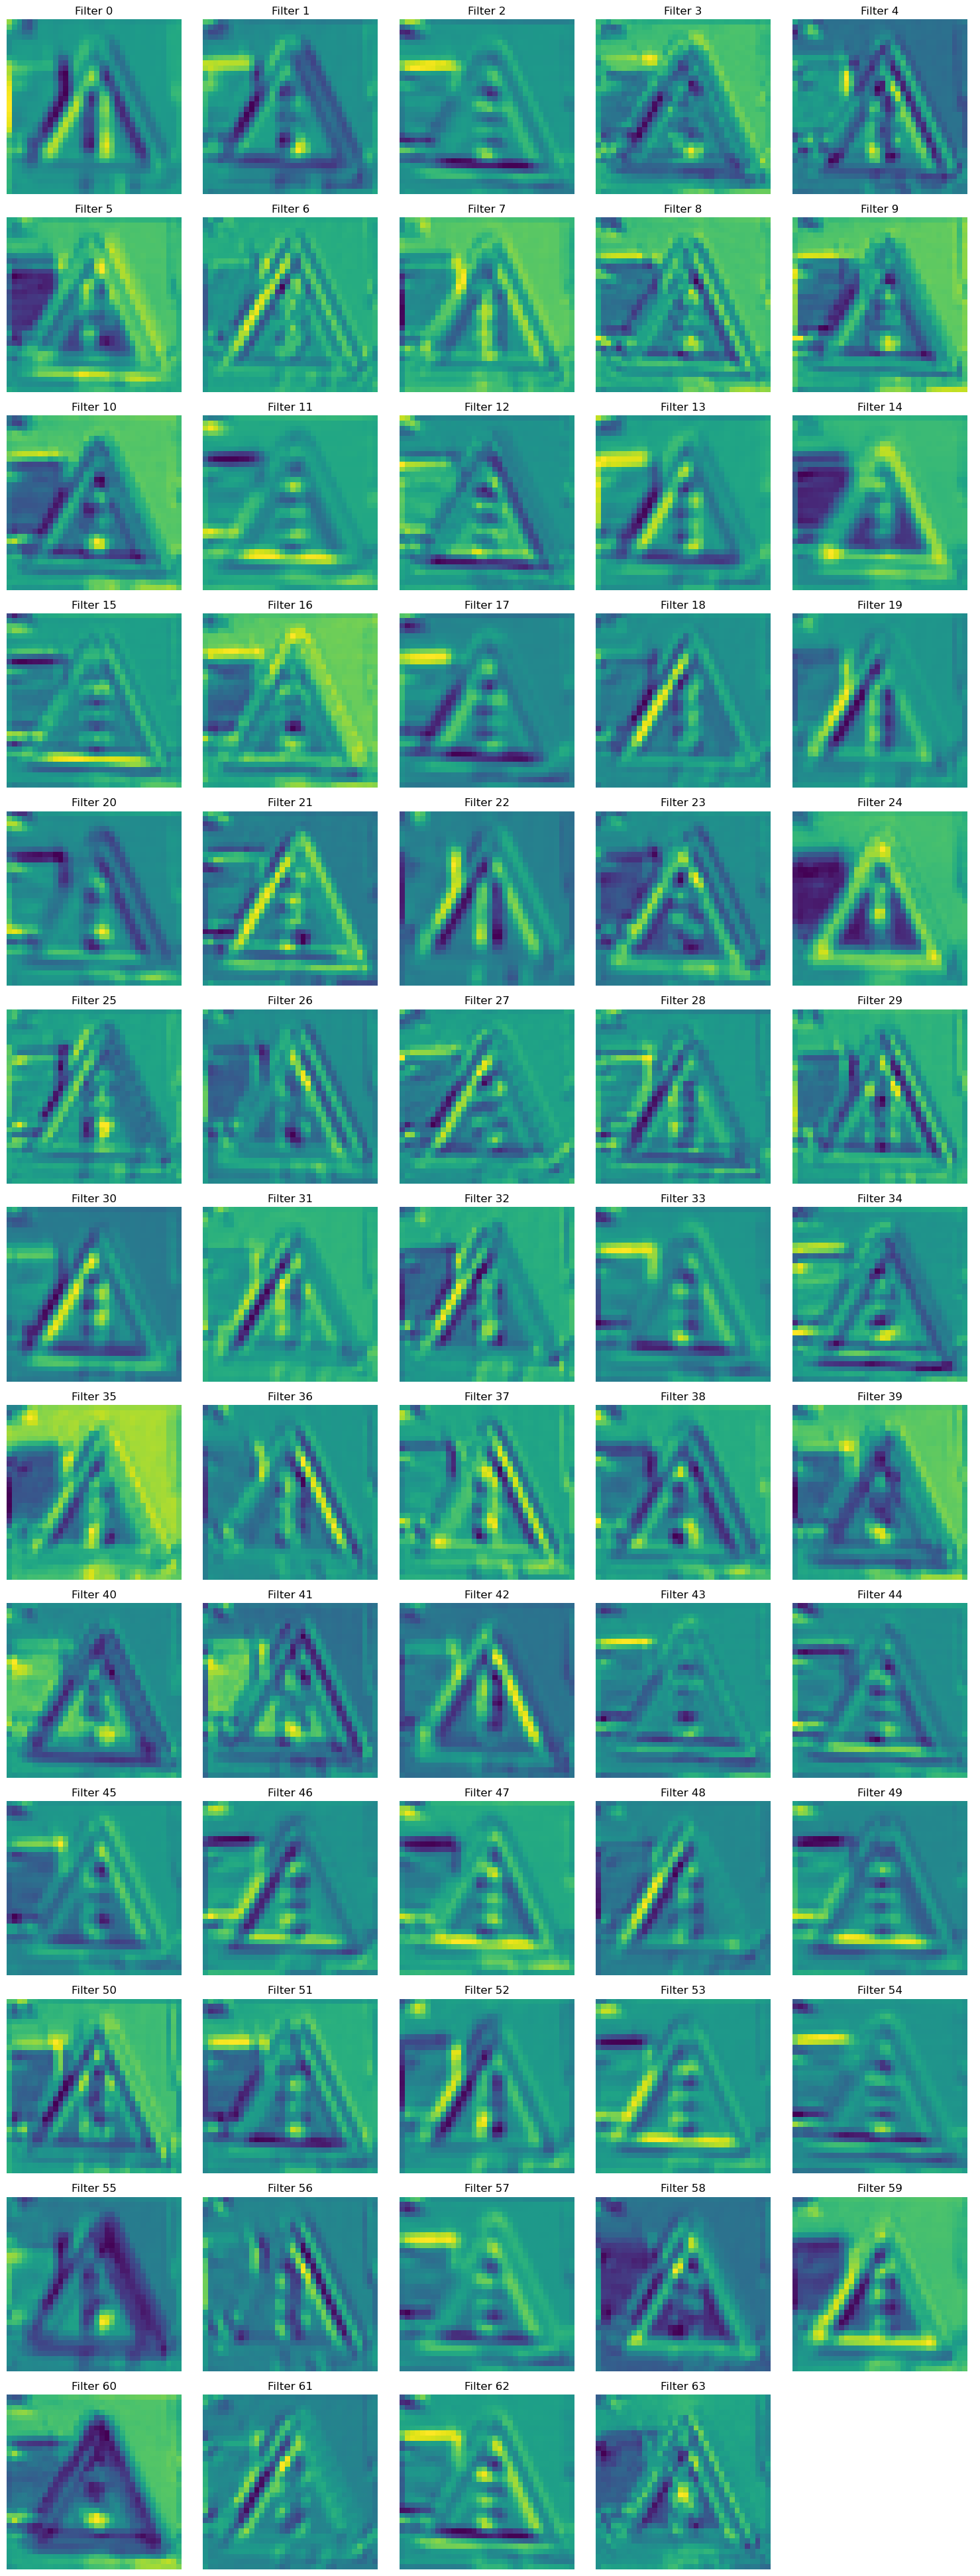

In [38]:
# The activation of the individual filters of the conv layer for the image defined when loading the model can be displayed here
act = activations['conv_layer1']
print(f"Shape of conv1 activations: {act.shape}")

# Number of filters in the first convolutional layer
num_filters = act.shape[1]

# Calculate number of rows for the plot
rows = math.ceil(num_filters / 5)

# Create subplots to display the filters
fig, axes = plt.subplots(rows, 5, figsize=(15, rows * 3))

# Display each filter activation
for idx in range(num_filters):
    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(act[0, idx].detach().cpu(), cmap='viridis')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Filter {idx}')

# Turn off axes for empty subplots
for idx in range(num_filters, rows * 5):
    row = idx // 5
    col = idx % 5
    axes[row, col].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### Activation Maximazation

In [ ]:
# The function optimizes an image to maximize the activation of a specific filter in a CNN layer.
def activation_maximization(model, layer_name, filter_index, input_size=(1, 3, 35, 35), lr=0.1, iterations=30):
    device = next(model.parameters()).device  # Get the device (CPU/GPU) from the model
    
    input_image = torch.randn(input_size, requires_grad=True, device=device)  # Initialize random image to optimize
    
    # CHANGE THE OPTIMIZER TO THE CORRECT ONE! 
    optimizer = optim.Adam([input_image], lr=lr, weight_decay=1e-6)  # Optimizer to update the image
    activations = {}  # Dictionary to store activations

    # Hook function to store activations from the layer
    def hook_function(module, input, output):
        activations[layer_name] = output

    # Register the hook for the given layer
    layer = dict(model.named_modules())[layer_name]
    hook = layer.register_forward_hook(hook_function)

    # Optimization loop
    for i in range(iterations):
        optimizer.zero_grad()
        model(input_image)
        act = activations[layer_name][0, filter_index]
        loss = -torch.mean(act)
        loss.backward()
        optimizer.step()
        input_image.data = torch.clamp(input_image.data, 0, 1)

    hook.remove()  # Remove the hook after optimization
    return input_image.detach()  # Return the optimized image


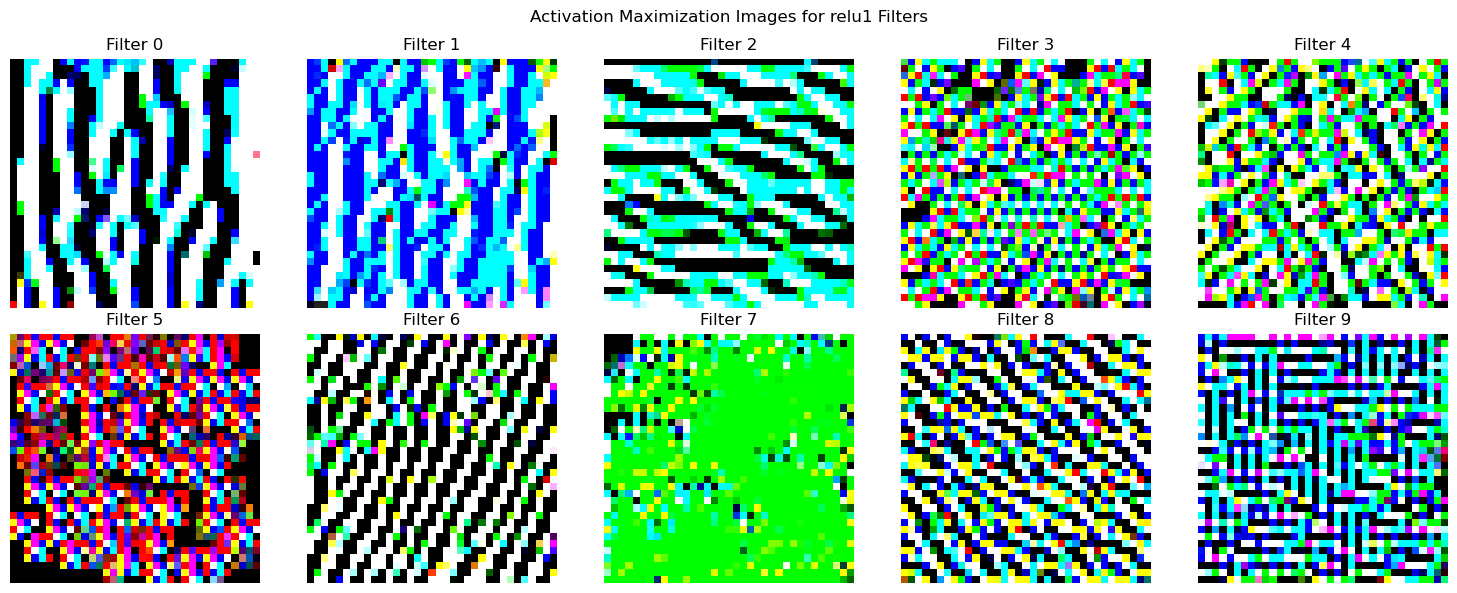

In [42]:
# Activation Maximization for relu1, first 10 Filters will be shown 
conv_layer1num_filters_relu1 = trained_model.conv_layer1.out_channels
am_images_relu1 = []

for filter_idx in range(conv_layer1num_filters_relu1):
    am_image = activation_maximization(trained_model, 'relu1', filter_idx, input_size=(1, 3, 35, 35), lr=0.1, iterations=30)
    am_images_relu1.append(am_image)


fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, am_image in enumerate(am_images_relu1[:10]): 
    row = idx // 5
    col = idx % 5
    axes[row, col].imshow(am_image.squeeze().permute(1, 2, 0).cpu().numpy()) 
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Filter {idx}')

plt.suptitle('Activation Maximization Images for relu1 Filters')
plt.tight_layout()
plt.show()


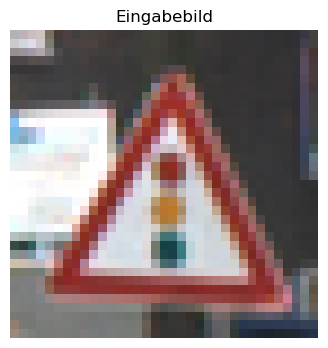

Shape der Aktivierung nach ReLU1: torch.Size([1, 64, 34, 34])
Shape von Filter 0: (34, 34)
Shape von Filter 1: (34, 34)
Shape von Filter 2: (34, 34)
Shape von Filter 3: (34, 34)
Shape von Filter 4: (34, 34)
Shape von Filter 5: (34, 34)
Shape von Filter 6: (34, 34)
Shape von Filter 7: (34, 34)
Shape von Filter 8: (34, 34)
Shape von Filter 9: (34, 34)


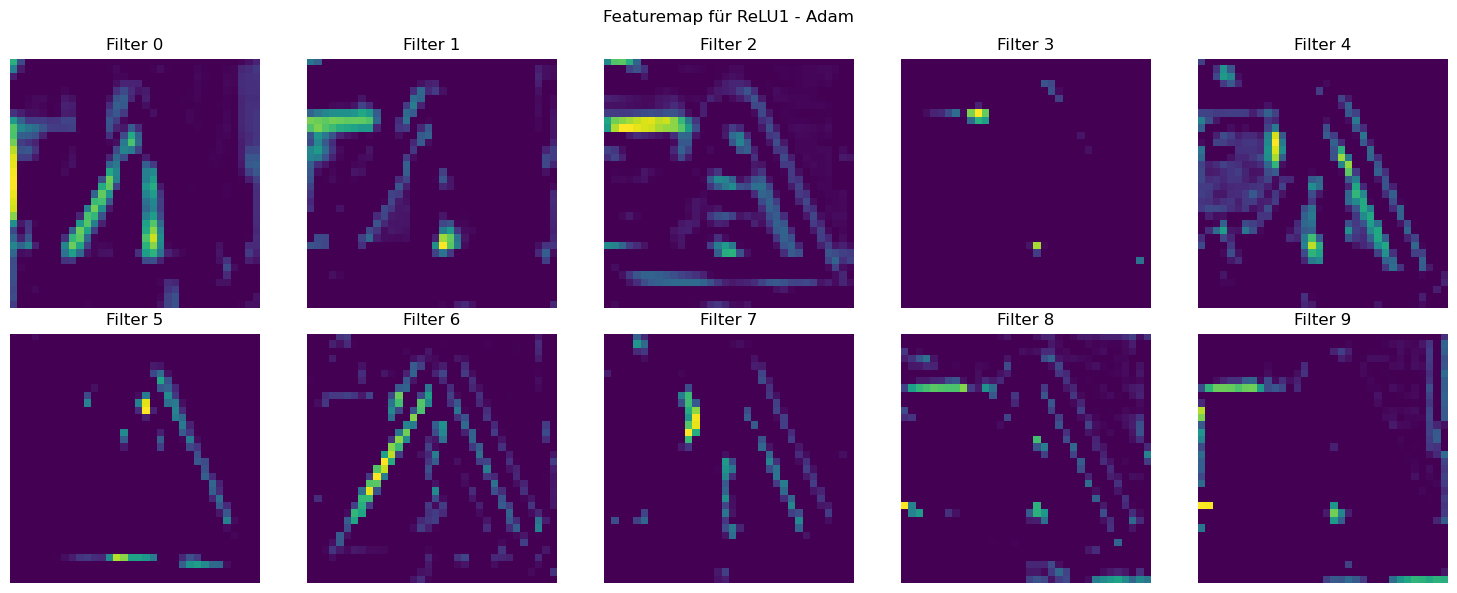

In [44]:
# Visualizes the original image and displays the activation maps (feature maps) of the first 10 filters after the first ReLU layer.
image = Image.open(image_path).convert('RGB')
input_image = transform(image).unsqueeze(0)  # Transform the image to tensor

input_image = input_image.to(device)

trained_model = Net(num_classes=43)
trained_model.to(device)
trained_model.load_state_dict(torch.load(model_path, map_location=device))

with torch.no_grad():
    out_conv1 = trained_model.relu1(trained_model.conv_layer1(input_image))  # Get activations from the first ReLU layer
    out_pool1 = trained_model.max_pool1(out_conv1)
    out_conv2 = trained_model.relu2(trained_model.conv_layer2(out_pool1))

# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis('off')
plt.title("Eingabebild")
plt.show()

print("Shape der Aktivierung nach ReLU1:", out_conv1.shape)

num_filters = min(10, out_conv1.shape[1])  # Limit to first 10 filters
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Visualize the activation maps of the first filters
for i in range(num_filters):
    activation_map = out_conv1[0, i].cpu().numpy()

    print(f"Shape von Filter {i}: {activation_map.shape}")

    if activation_map.ndim == 1:
        size = int(activation_map.size ** 0.5)
        assert size * size == activation_map.size, f"Aktivierung {i} hat kein quadratisches Shape!"
        activation_map = activation_map.reshape(size, size)
    
    row = i // 5
    col = i % 5
    axes[row, col].imshow(activation_map, cmap='viridis')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Filter {i}')

plt.suptitle("Featuremap für ReLU1 - Adam")
plt.tight_layout()
plt.show()


### Grad Cam

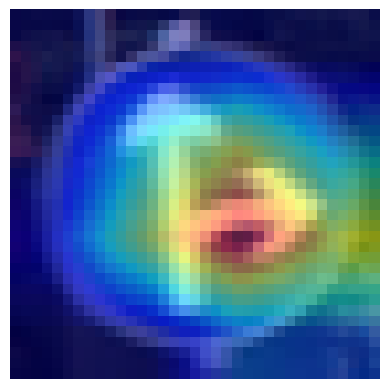

In [81]:
# The Grad Cam visualization is implemented here
def grad_cam(model, input_image, target_class, layer_name):
    model.eval()  

    gradients = {}
    activations = {}

    # Hooks to capture activations and gradients
    def backward_hook(module, grad_input, grad_output):
        gradients[layer_name] = grad_output[0]

    def forward_hook(module, input, output):
        activations[layer_name] = output

    layer = dict(model.named_modules())[layer_name]
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    input_image = input_image.unsqueeze(0).to(next(model.parameters()).device)  # Prepare input
    output = model(input_image)

    model.zero_grad()
    target_score = output[0, target_class]  # Target class score
    target_score.backward()

    grads = gradients[layer_name]
    acts = activations[layer_name]
    pooled_grads = torch.mean(grads, dim=(2, 3))  # Pool gradients

    acts = acts * pooled_grads.view(1, -1, 1, 1)
    heatmap = torch.mean(acts, dim=1).squeeze().detach().cpu().numpy()

    heatmap = np.maximum(heatmap, 0)  # Normalize heatmap
    heatmap /= np.max(heatmap)

    return heatmap


def show_grad_cam(image, heatmap, alpha=0.5):
    image = (image - image.min()) / (image.max() - image.min())  # Normalize image

    heatmap_tensor = torch.tensor(heatmap).unsqueeze(0).unsqueeze(0)
    heatmap_resized = F.interpolate(heatmap_tensor, size=image.shape[:2], mode='bilinear', align_corners=False)
    heatmap_resized = heatmap_resized.squeeze().numpy() 
    heatmap_resized = np.uint8(255 * heatmap_resized)  # Convert to heatmap format

    heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]  # Apply colormap
    heatmap_colored = heatmap_colored / np.max(heatmap_colored)

    overlay = alpha * heatmap_colored + (1 - alpha) * image  # Combine heatmap with image
    overlay = overlay / np.max(overlay)

    plt.imshow(overlay)
    plt.axis('off')
    plt.show()


def load_image(image_path, input_size=(3, 35, 35)):
    transform = transforms.Compose([
        transforms.Resize((input_size[1], input_size[2])),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    original_image = np.array(image) / 255.0  # Normalize original image
    image_tensor = transform(image)
    return image_tensor, original_image


image_tensor, original_image = load_image(image_path)

# The desired layer and the "target class" must be defined here.
layer_name = "conv_layer5" 
target_class = 40

heatmap = grad_cam(trained_model, image_tensor, target_class, layer_name)  # Generate GradCAM heatmap
show_grad_cam(original_image, heatmap)  # Display heatmap overlay


### LIME

100%|██████████| 1000/1000 [00:05<00:00, 168.07it/s]


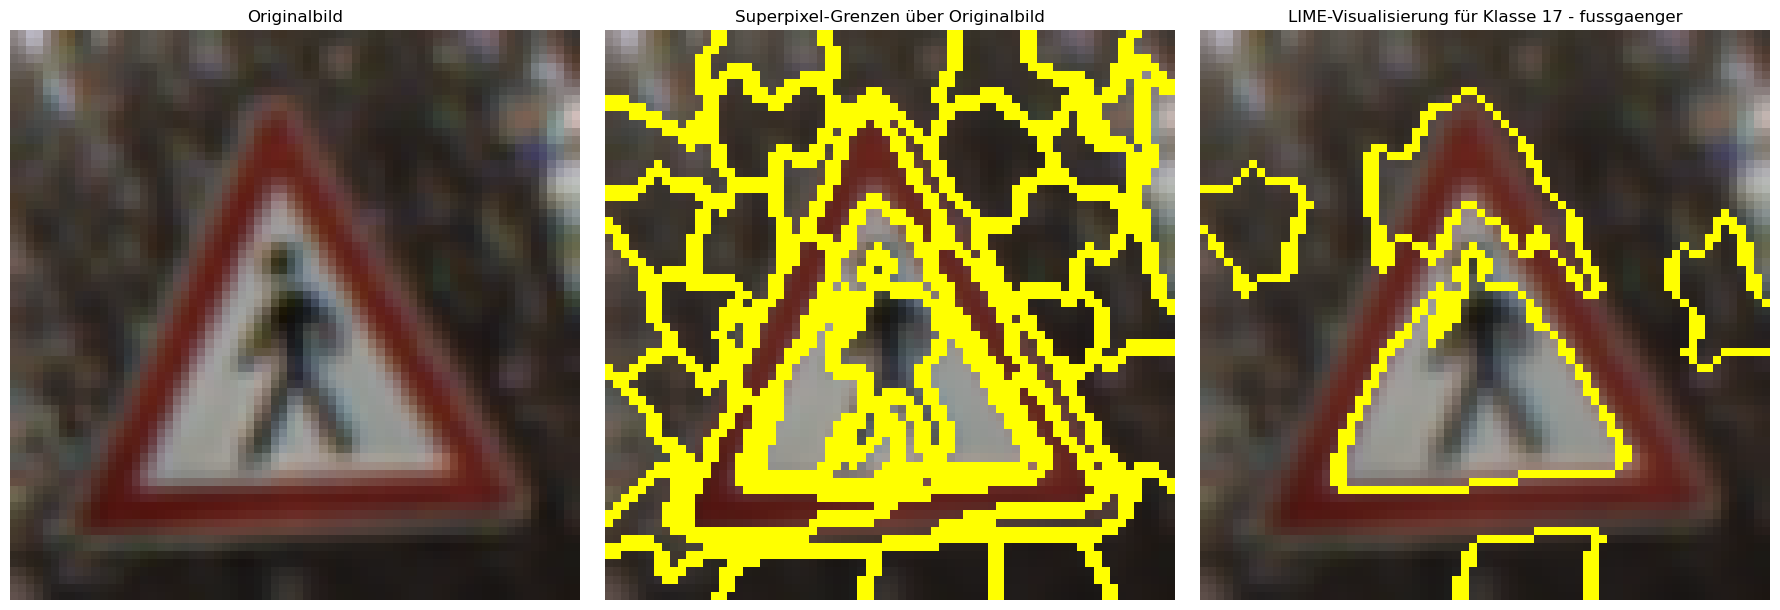

In [89]:
# Transformation for resizing image to 70x70 for model
def transform_image_for_model(image):
    transform = transforms.Compose([
        transforms.Resize((70, 70)), 
    ])
    return transform(image)

# Predict the probabilities for each class
def predict_proba(images):
    transform = transforms.Compose([
        transforms.Resize((35, 35)),
        transforms.ToTensor()
    ])
    # Convert the images to tensor format
    images_tensor = torch.stack([
        transform(Image.fromarray((image * 255).astype(np.uint8))).to(device) for image in images
    ])
    
    with torch.no_grad():
        # Model inference
        outputs = trained_model(images_tensor)
        probs = torch.softmax(outputs, dim=1)
    
    return probs.cpu().numpy()

# Initialize LIME explainer
explainer = LimeImageExplainer()
example_image = Image.open(image_path).convert('RGB')
transformed_image = transform_image_for_model(example_image)
transformed_image_np = np.array(transformed_image) / 255.0

# Custom segmentation function for LIME
def custom_segmentation(image):
    return slic(image, n_segments=50, compactness=10, start_label=1)

# Explain the prediction with LIME
explanation = explainer.explain_instance(
    transformed_image_np,
    predict_proba,
    top_labels=1,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=custom_segmentation
)

label_to_explain = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label=label_to_explain,
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.01
)

# Generate superpixels and boundaries
segments = slic(transformed_image_np, n_segments=50, compactness=10, start_label=1)
boundaries_image = mark_boundaries(transformed_image_np, segments)

# Plot original image, boundaries, and LIME visualization
plt.figure(figsize=(18, 6))

# Plot Original Image
plt.subplot(1, 3, 1)
plt.imshow(example_image.resize((70, 70)))
plt.title("Originalbild")
plt.axis("off")

# Plot Superpixel Boundaries
plt.subplot(1, 3, 2)
plt.imshow(boundaries_image)
plt.title("Superpixel-Grenzen über Originalbild")
plt.axis("off")

# Plot LIME Explanation
plt.subplot(1, 3, 3)
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME-Visualisierung für Klasse {label_to_explain} - {test_dataset.classes[label_to_explain]}")
plt.axis("off")

# Final plot adjustments
plt.tight_layout()
plt.show()


### Here a neuron can be maximally activated to see and output the resulting image

/Users/linuspfeifer/opt/anaconda3/envs/xai/lib/python3.9/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Iteration 0/100, Loss: 2.3295698165893555
Iteration 10/100, Loss: -0.5496769547462463
Iteration 20/100, Loss: -0.7081238627433777
Iteration 30/100, Loss: -0.7106940150260925
Iteration 40/100, Loss: -0.41370248794555664
Iteration 50/100, Loss: -0.713402509689331
Iteration 60/100, Loss: -0.6736172437667847
Iteration 70/100, Loss: -0.7208306789398193
Iteration 80/100, Loss: -0.6652659773826599
Iteration 90/100, Loss: -0.6823891401290894


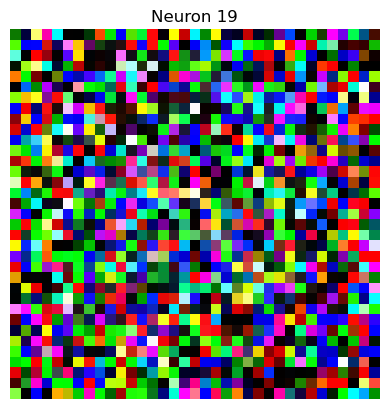

In [48]:
# Select one of the 43 output neurons
target_neuron = 19

# Set input size and initialize random image
input_size = (1, 3, 35, 35)  
input_image = torch.randn(input_size, requires_grad=True, device=device)

# Set the model to evaluation mode
trained_model.eval()

# Initialize optimizer
optimizer = optim.SGD([input_image], lr=0.1)

num_iterations = 100
for i in range(num_iterations):
    optimizer.zero_grad()
    output = trained_model(input_image)
    neuron_activation = output[0, target_neuron]
    loss = -neuron_activation
    loss.backward()
    optimizer.step()
    input_image.data.clamp_(0, 1)

    if i % 10 == 0:
        print(f'Iteration {i}/{num_iterations}, Loss: {loss.item()}')

# Process and display the resulting image
result = input_image.detach().cpu().squeeze().permute(1, 2, 0).numpy()
result = (result - result.min()) / (result.max() - result.min())

plt.imshow(result)
plt.axis('off')
plt.title(f'Neuron {target_neuron}')
plt.show()


In [ ]:
# This shows which 3 classes the imported model considers most probable
trained_model.eval()
trained_model.to(device)


def predict_image_class(image_path):
    # Open and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device) 
    
    # Get model prediction
    with torch.no_grad():
        output = trained_model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        top_probs, top_indices = torch.topk(probabilities, 3)
        top_probs = top_probs.cpu().numpy()[0]
        top_indices = top_indices.cpu().numpy()[0]
    
    # Format the results
    top_classes = [(int(idx), float(prob)) for idx, prob in zip(top_indices, top_probs)]
    return top_classes

# Get and print top-3 predicted classes
top_classes = predict_image_class(image_path)

print('Die Top-3-Klassen sind:')
for idx, prob in top_classes:
    if idx < len(class_names):
        class_name = class_names[idx]
    else:
        class_name = f'Klasse {idx}'
    print(f'{class_name}: {prob * 100:.2f}% Wahrscheinlichkeit')


### Feature Map of last FC Layer

Die 3 stärksten aktivierten Neuronen in fc9:
1. Neuron 40: Aktivierung = 7.0507
2. Neuron 39: Aktivierung = 6.2394
3. Neuron 38: Aktivierung = 1.3729


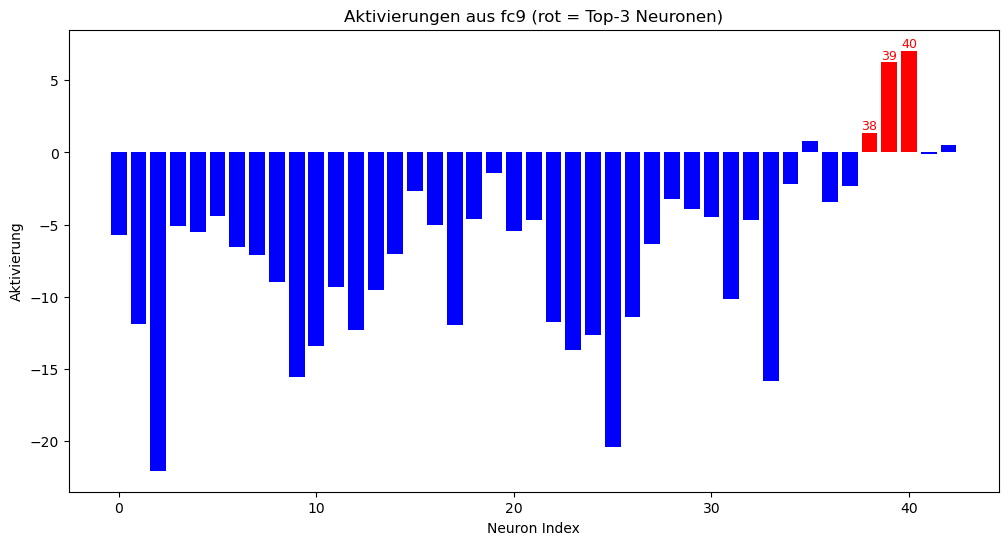

In [83]:
# The activation, i.e. the feature map of the last Fully Connected Layer, can be output here
def visualize_fc_layer_with_path_and_top_neurons(model, layer_name, image_path, top_n=5):
    model.eval()
    activations = {}

    def hook_fn(module, input, output):
        activations[layer_name] = output

    # Register hook to capture activations
    target_layer = dict(model.named_modules())[layer_name]
    target_layer.register_forward_hook(hook_fn)

    transform = transforms.Compose([
        transforms.Resize((35, 35)),  
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert('RGB')
    input_image = transform(image).unsqueeze(0).to(next(model.parameters()).device) 

    with torch.no_grad():
        model(input_image)

    # Extract activations and get top N neurons
    features = activations[layer_name][0].cpu().detach().numpy()
    top_indices = np.argsort(features)[-top_n:][::-1]  
    top_activations = features[top_indices]  

    print(f"Die {top_n} stärksten aktivierten Neuronen in {layer_name}:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. Neuron {idx}: Aktivierung = {top_activations[i]:.4f}")

    # Plot activation values
    plt.figure(figsize=(12, 6))
    colors = ['red' if i in top_indices else 'blue' for i in range(len(features))]
    plt.bar(range(len(features)), features, color=colors)
    plt.title(f'Aktivierungen aus {layer_name} (rot = Top-{top_n} Neuronen)')
    plt.xlabel('Neuron Index')
    plt.ylabel('Aktivierung')

    for i, idx in enumerate(top_indices):
        plt.text(idx, features[idx], f"{idx}", ha='center', va='bottom', fontsize=9, color='red')

    plt.show()
 
visualize_fc_layer_with_path_and_top_neurons(trained_model, 'fc9', image_path, top_n=3)
